In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score

In [2]:
# Set random seed for reproducibility
random_seed = 1
torch.backends.cudnn.enabled = False  # Disable CuDNN for deterministic behavior
torch.manual_seed(random_seed)  # Set manual seed for PyTorch


In [3]:
# Define dataset paths
root_dir = '/kaggle/input/iuss-23-24-automatic-diagnosis-breast-cancer/training_set'
benign_dir = f'{root_dir}/benign'  # Path to benign images
malignant_dir = f'{root_dir}/malignant'  # Path to malignant images

In [4]:
# Function to create a dataset info dataframe
def create_dataset_info_dataframe(dataset_path):
    data = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}
    
    # Loop through benign and malignant directories
    for label in ['benign', 'malignant']:
        class_dir = os.path.join(dataset_path, label)
        # Loop through files in the directory
        for file in os.listdir(class_dir):
            if file.endswith('.png') and not '_mask' in file:  # Check if the file is an image
                study_id = file.split('.')[0]  # Extract study ID
                img_path = os.path.join(class_dir, file)  # Full path to the image
                img = Image.open(img_path)  # Open the image
                x_dim, y_dim = img.size  # Get image dimensions
                # Count the number of masks for the study
                num_of_masks = sum(1 for f in os.listdir(class_dir) if f.startswith(study_id) and '_mask' in f)
                # Append data to the dictionary
                data['x_dim'].append(x_dim)
                data['y_dim'].append(y_dim)
                data['label'].append(label)
                data['num_of_masks'].append(num_of_masks)
                data['path'].append(img_path)

    return pd.DataFrame(data)  # Return the dataframe

In [5]:
# Load dataset into a dataframe
df = create_dataset_info_dataframe(root_dir)

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['label'])

In [6]:
# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to smaller dimensions
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [7]:
# Custom dataset class for breast cancer images
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  # Dataframe containing image paths and labels
        self.transform = transform  # Image transformations

    def __len__(self):
        return len(self.dataframe)  # Return the number of images in the dataset

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']  # Get the image path
        img = Image.open(img_path).convert('RGB')  # Open and convert image to RGB

        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Convert label to binary (1 for malignant, 0 for benign)
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label  # Return the image and its label

In [8]:
# Create training and validation datasets and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

val_dataset = BreastCancerDataset(dataframe=val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

In [9]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels, 32 output channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels, 64 output channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 64 input channels, 128 output channels
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 128 input channels, 256 output channels

        # Define fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Fully connected layer with 512 units
        self.fc2 = nn.Linear(512, 1)  # Output layer with 1 unit (binary classification)

    def forward(self, x):
        # Apply convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling with 2x2 window
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 256*8*8)
        
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = self.fc2(x)  # Output layer (logits)

        return x  # Return the output logits


Using device: cuda
Epoch [1/20], Train Loss: 0.7144, Train ROC AUC: 0.6764, Val Loss: 0.6499, Val ROC AUC: 0.5673
Epoch [2/20], Train Loss: 0.5800, Train ROC AUC: 0.7794, Val Loss: 0.5895, Val ROC AUC: 0.6767
Epoch [3/20], Train Loss: 0.5642, Train ROC AUC: 0.7966, Val Loss: 0.6882, Val ROC AUC: 0.6394
Epoch [4/20], Train Loss: 0.5030, Train ROC AUC: 0.8644, Val Loss: 0.5841, Val ROC AUC: 0.6927
Epoch [5/20], Train Loss: 0.4518, Train ROC AUC: 0.9265, Val Loss: 0.5421, Val ROC AUC: 0.7147
Epoch [6/20], Train Loss: 0.4162, Train ROC AUC: 0.9244, Val Loss: 0.6314, Val ROC AUC: 0.7244
Epoch [7/20], Train Loss: 0.3659, Train ROC AUC: 0.9720, Val Loss: 0.5709, Val ROC AUC: 0.7308
Epoch [8/20], Train Loss: 0.3307, Train ROC AUC: 0.9765, Val Loss: 0.6227, Val ROC AUC: 0.7360
Epoch [9/20], Train Loss: 0.2378, Train ROC AUC: 0.9887, Val Loss: 0.6697, Val ROC AUC: 0.7993
Epoch [10/20], Train Loss: 0.2223, Train ROC AUC: 0.9757, Val Loss: 0.7474, Val ROC AUC: 0.7468
Epoch [11/20], Train Loss: 0.1

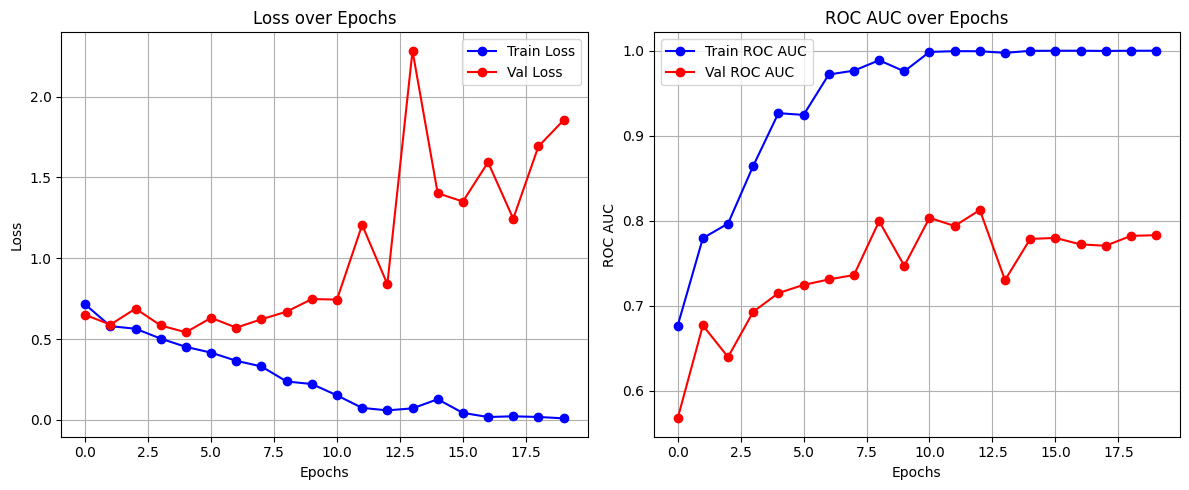

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize the model and move it to the GPU
model = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(imgs)  # Forward pass
            probs = torch.sigmoid(outputs)  # Get predicted probabilities
            all_labels.extend(labels.cpu().numpy())  # Move labels back to CPU
            all_preds.extend(probs.cpu().numpy())  # Move predictions back to CPU

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store loss and ROC AUC values
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()  # Accumulate loss

    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on the validation set
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()  # Accumulate validation loss

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Tuning CNN hyparparameter**


In [11]:
class SimpleCNN_02(nn.Module):
    def __init__(self):
        super(SimpleCNN_02, self).__init__()
        
        # Convolutional Layers (Changes in the number of output channels and deeper layers)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Conv1: 3 channels to 64 channels (Increased depth)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Conv2: 64 channels to 128 channels (Increased depth)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Conv3: 128 channels to 256 channels (Increased depth)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Conv4: 256 channels to 512 channels (Increased depth)
        
        # Batch Normalization Layers (Added for better training stability and faster convergence)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization after Conv1
        self.bn2 = nn.BatchNorm2d(128)  # Batch Normalization after Conv2
        self.bn3 = nn.BatchNorm2d(256)  # Batch Normalization after Conv3
        self.bn4 = nn.BatchNorm2d(512)  # Batch Normalization after Conv4
        
        # Fully Connected Layers (Changed number of units in fc1 due to increased depth)
        # After 4 max pooling layers, the image size will be reduced from 128x128 -> 8x8
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # Adjusted for the 128x128 image size after pooling (Larger FC layer)
        self.fc2 = nn.Linear(1024, 1)  # Output layer (single logit, same as before)
        
        # Dropout Layer (Added to prevent overfitting by randomly dropping connections during training)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability to reduce overfitting

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling
        x = F.relu(self.bn1(self.conv1(x)))  # BatchNorm + Conv1 + ReLU (New)
        x = F.max_pool2d(x, 2)  # Pooling layer 1 (same as before)
        
        x = F.relu(self.bn2(self.conv2(x)))  # BatchNorm + Conv2 + ReLU (New)
        x = F.max_pool2d(x, 2)  # Pooling layer 2 (same as before)
        
        x = F.relu(self.bn3(self.conv3(x)))  # BatchNorm + Conv3 + ReLU (New)
        x = F.max_pool2d(x, 2)  # Pooling layer 3 (same as before)
        
        x = F.relu(self.bn4(self.conv4(x)))  # BatchNorm + Conv4 + ReLU (New)
        x = F.max_pool2d(x, 2)  # Pooling layer 4 (same as before)
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 512 * 8 * 8) (same as before)
        
        # Apply fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))  # Fully connected layer 1 + ReLU (same as before)
        x = self.dropout(x)  # Dropout layer to reduce overfitting (New)
        x = self.fc2(x)  # Logits output (no activation function here, BCEWithLogitsLoss applies sigmoid) (same as before)
        
        return x


Using device: cuda
Epoch [1/20], Train Loss: 10.6365, Train ROC AUC: 0.7524, Val Loss: 5.6016, Val ROC AUC: 0.7047
Epoch [2/20], Train Loss: 2.5042, Train ROC AUC: 0.7677, Val Loss: 0.7130, Val ROC AUC: 0.7672
Epoch [3/20], Train Loss: 0.7142, Train ROC AUC: 0.8343, Val Loss: 0.5747, Val ROC AUC: 0.8005
Epoch [4/20], Train Loss: 0.5252, Train ROC AUC: 0.8580, Val Loss: 0.4628, Val ROC AUC: 0.8177
Epoch [5/20], Train Loss: 0.5170, Train ROC AUC: 0.8637, Val Loss: 0.4909, Val ROC AUC: 0.8081
Epoch [6/20], Train Loss: 0.4903, Train ROC AUC: 0.8713, Val Loss: 0.6047, Val ROC AUC: 0.8385
Epoch [7/20], Train Loss: 0.4413, Train ROC AUC: 0.8889, Val Loss: 0.4513, Val ROC AUC: 0.8361
Epoch [8/20], Train Loss: 0.4650, Train ROC AUC: 0.9071, Val Loss: 0.4220, Val ROC AUC: 0.8522
Epoch [9/20], Train Loss: 0.4596, Train ROC AUC: 0.9129, Val Loss: 0.4874, Val ROC AUC: 0.8341
Epoch [10/20], Train Loss: 0.4677, Train ROC AUC: 0.9251, Val Loss: 0.4326, Val ROC AUC: 0.8630
Epoch [11/20], Train Loss: 0.

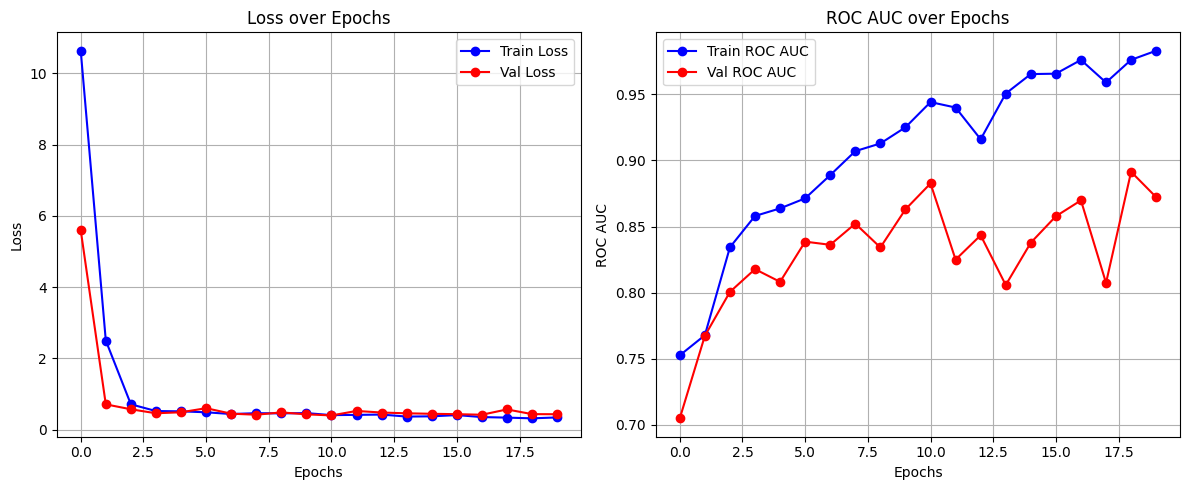

In [12]:
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the device (GPU or CPU)
model_2 = SimpleCNN_02().to(device)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss function
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model_2.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_2(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model_2.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        # Forward pass
        outputs = model_2(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on the validation set
    model_2.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_2(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Data Augmentation

In [13]:
transform_d = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),      # Random rotation by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
# Create dataset and dataloaders using the new transformation `transform_d`
train_dataset = BreastCancerDataset(dataframe=train_df, transform=transform_d)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

val_dataset = BreastCancerDataset(dataframe=val_df, transform=transform_d)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4)

In [15]:
# Define the model
class SimpleCNN_03(nn.Module):
    def __init__(self):
        super(SimpleCNN_03, self).__init__()

        # Convolutional Layers (No changes here between SimpleCNN_02 and SimpleCNN_03)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Conv1: 3 channels to 64 channels (same as before)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Conv2: 64 channels to 128 channels (same as before)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Conv3: 128 channels to 256 channels (same as before)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Conv4: 256 channels to 512 channels (same as before)

        # Batch Normalization Layers (Same as in SimpleCNN_02)
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm after Conv1 (same as before)
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm after Conv2 (same as before)
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm after Conv3 (same as before)
        self.bn4 = nn.BatchNorm2d(512)  # BatchNorm after Conv4 (same as before)

        # Fully Connected Layers (No change in the number of units here)
        # After 4 max pooling layers, the image size will be reduced from 128x128 -> 8x8
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # Adjusted for the 128x128 image size after pooling (same as before)
        self.fc2 = nn.Linear(1024, 1)  # Output layer (single logit, same as before)

        # Dropout Layer (Same dropout layer from SimpleCNN_02)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability (same as before)

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling (No change here between SimpleCNN_02 and SimpleCNN_03)
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 1 (same as before)

        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 2 (same as before)

        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 3 (same as before)

        x = F.relu(self.bn4(self.conv4(x)))  # Conv4 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 4 (same as before)

        # Flatten the tensor for fully connected layers (same as in SimpleCNN_02)
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 512 * 8 * 8) (same as before)

        # Apply fully connected layers with ReLU activations and dropout (same as in SimpleCNN_02)
        x = F.relu(self.fc1(x))  # Fully connected layer 1 + ReLU (same as before)
        x = self.dropout(x)  # Dropout layer to reduce overfitting (same as before)
        x = self.fc2(x)  # Logits output (no activation function here, BCEWithLogitsLoss applies sigmoid) (same as before)

        return x  # Return the final logits (same as before)


Using device: cuda
Epoch [1/20], Train Loss: 10.1789, Train ROC AUC: 0.6977, Val Loss: 3.0008, Val ROC AUC: 0.6831
Epoch [2/20], Train Loss: 1.5106, Train ROC AUC: 0.6742, Val Loss: 0.6866, Val ROC AUC: 0.6759
Epoch [3/20], Train Loss: 0.7006, Train ROC AUC: 0.7964, Val Loss: 0.5165, Val ROC AUC: 0.7576
Epoch [4/20], Train Loss: 0.5799, Train ROC AUC: 0.7828, Val Loss: 0.5358, Val ROC AUC: 0.7556
Epoch [5/20], Train Loss: 0.5696, Train ROC AUC: 0.8171, Val Loss: 0.4991, Val ROC AUC: 0.7624
Epoch [6/20], Train Loss: 0.5466, Train ROC AUC: 0.7913, Val Loss: 0.5634, Val ROC AUC: 0.7256
Epoch [7/20], Train Loss: 0.5670, Train ROC AUC: 0.8179, Val Loss: 0.5199, Val ROC AUC: 0.7592
Epoch [8/20], Train Loss: 0.5152, Train ROC AUC: 0.8064, Val Loss: 0.5647, Val ROC AUC: 0.7368
Epoch [9/20], Train Loss: 0.6167, Train ROC AUC: 0.7858, Val Loss: 0.5574, Val ROC AUC: 0.7284
Epoch [10/20], Train Loss: 0.5527, Train ROC AUC: 0.8391, Val Loss: 0.5397, Val ROC AUC: 0.7720
Epoch [11/20], Train Loss: 0.

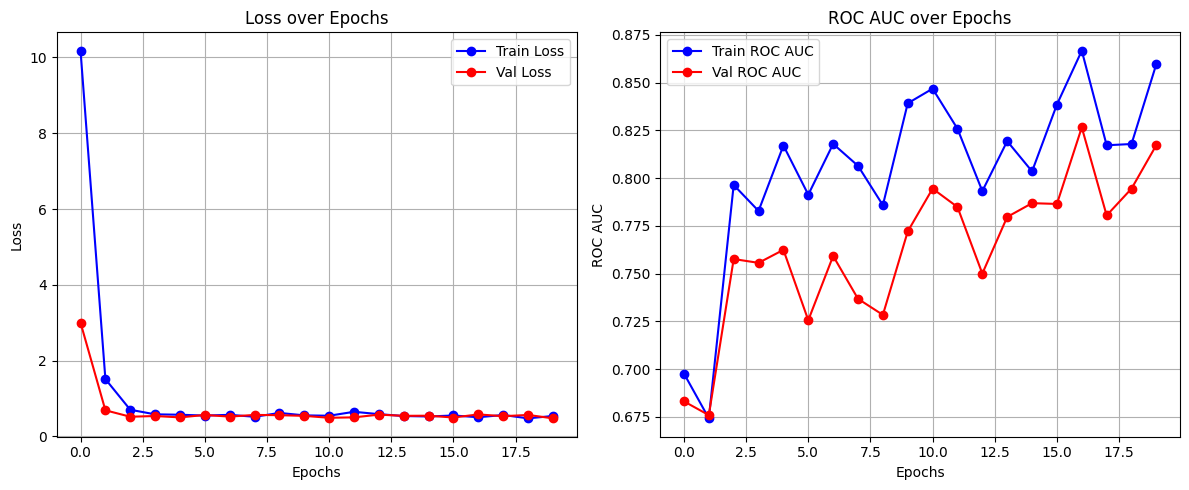

In [16]:
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the GPU if available
model_3 = SimpleCNN_03().to(device)  # Move model to GPU

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss function
optimizer = Adam(model_3.parameters(), lr=0.001)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model_3.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_3(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20
for epoch in range(epochs):
    model_3.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        # Forward pass
        outputs = model_3(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on the validation set
    model_3.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_3(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


It showed overfit. So tuning:

In [17]:
# Define the model
class SimpleCNN_04(nn.Module):
    def __init__(self):
        super(SimpleCNN_04, self).__init__()

        # Convolutional Layers (Identical to SimpleCNN_03)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Conv1: 3 channels to 64 channels (same as before)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Conv2: 64 channels to 128 channels (same as before)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Conv3: 128 channels to 256 channels (same as before)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  # Conv4: 256 channels to 512 channels (same as before)

        # Batch Normalization Layers (Identical to SimpleCNN_03)
        self.bn1 = nn.BatchNorm2d(64)  # BatchNorm after Conv1 (same as before)
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm after Conv2 (same as before)
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm after Conv3 (same as before)
        self.bn4 = nn.BatchNorm2d(512)  # BatchNorm after Conv4 (same as before)

        # Fully Connected Layers (Identical to SimpleCNN_03)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # Adjusted for the 128x128 image size after pooling (same as before)
        self.fc2 = nn.Linear(1024, 1)  # Output layer (single logit, same as before)

        # Dropout Layer (Key Difference Here)
        self.dropout = nn.Dropout(0.6)  # Increased dropout rate from 0.5 to 0.6 (this is the key change)

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling (Same as SimpleCNN_03)
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 1 (same as before)

        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 2 (same as before)

        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 3 (same as before)

        x = F.relu(self.bn4(self.conv4(x)))  # Conv4 -> BatchNorm -> ReLU (same as before)
        x = F.max_pool2d(x, 2)  # Pooling layer 4 (same as before)

        # Flatten the tensor for fully connected layers (same as SimpleCNN_03)
        x = x.view(x.size(0), -1)  # Flatten the tensor (batch_size, 512 * 8 * 8) (same as before)

        # Apply fully connected layers with ReLU activations and dropout (same as SimpleCNN_03)
        x = F.relu(self.fc1(x))  # Fully connected layer 1 + ReLU (same as before)
        x = self.dropout(x)  # Dropout layer to reduce overfitting (key change: dropout rate increased)
        x = self.fc2(x)  # Logits output (no activation function here, BCEWithLogitsLoss applies sigmoid) (same as before)

        return x  


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Train Loss: 8.9776, Train ROC AUC: 0.6956, Val Loss: 0.9921, Val ROC AUC: 0.5841
Epoch [2/20], Train Loss: 1.6353, Train ROC AUC: 0.7466, Val Loss: 0.9884, Val ROC AUC: 0.6867
Epoch [3/20], Train Loss: 0.6450, Train ROC AUC: 0.8513, Val Loss: 0.5055, Val ROC AUC: 0.7853
Epoch [4/20], Train Loss: 0.5208, Train ROC AUC: 0.8121, Val Loss: 0.4570, Val ROC AUC: 0.7829
Epoch [5/20], Train Loss: 0.5469, Train ROC AUC: 0.8798, Val Loss: 0.4892, Val ROC AUC: 0.8618
Epoch [6/20], Train Loss: 0.5493, Train ROC AUC: 0.8636, Val Loss: 0.5595, Val ROC AUC: 0.8013
Epoch [7/20], Train Loss: 0.5518, Train ROC AUC: 0.8469, Val Loss: 0.5647, Val ROC AUC: 0.7796
Epoch [8/20], Train Loss: 0.5177, Train ROC AUC: 0.7897, Val Loss: 0.8442, Val ROC AUC: 0.8005
Epoch [9/20], Train Loss: 0.6236, Train ROC AUC: 0.8834, Val Loss: 0.6113, Val ROC AUC: 0.8285
Epoch [10/20], Train Loss: 0.5731, Train ROC AUC: 0.8904, Val Loss: 0.4761, Val ROC AUC: 0.8189
Epoch [11/20], Train Loss: 0.5238, Train ROC AUC:

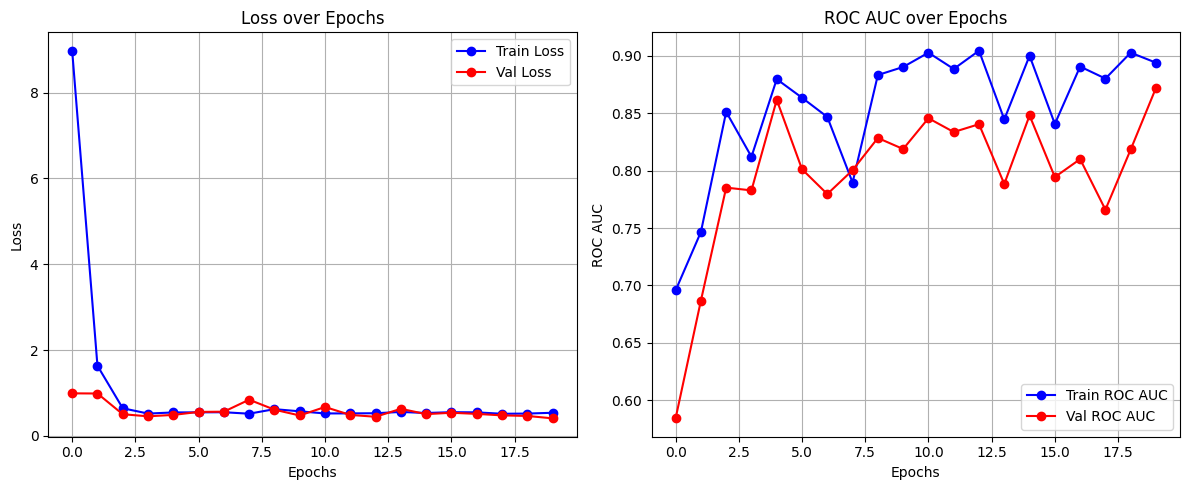

In [18]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model and move it to the GPU if available
model_4 = SimpleCNN_04().to(device)  # Move model to GPU

# Define loss and optimizer
optimizer = Adam(model_4.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight decay
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)  # Learning rate scheduler

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model_4.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_4(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20  # reduce one epoch for faster runtime
for epoch in range(epochs):
    model_4.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()

        # Forward pass
        outputs = model_4(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on the validation set
    model_4.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to GPU
            outputs = model_4(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Try ResNet 50

In [19]:
from torchvision import models
# Define ResNet50-based Model for Binary Classification
class ResNet50BinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNet50BinaryClassifier, self).__init__()
        
        # Load Pre-trained ResNet50 Model
        self.resnet50 = models.resnet50(pretrained=True)

        # Replace the fully connected layer (fc) with a new one for binary classification
        # The original fully connected layer has 1000 output units (for ImageNet classes)
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 1)  # Output layer with 1 unit for binary classification

        # Optional: Freeze early layers to prevent overfitting with small datasets
        # Freeze all layers except the final one (you can unfreeze more layers later if necessary)
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        # Unfreeze the final fully connected layer for training
        for param in self.resnet50.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Forward pass through the ResNet50 model
        x = self.resnet50(x)
        return x

In [20]:
# Initialize the ResNet50-based model
model_5 = ResNet50BinaryClassifier()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s] 


Epoch [1/8], Train Loss: 0.6441, Train ROC AUC: 0.7442, Val Loss: 0.5416, Val ROC AUC: 0.6803
Epoch [2/8], Train Loss: 0.5958, Train ROC AUC: 0.7716, Val Loss: 0.6284, Val ROC AUC: 0.7396
Epoch [3/8], Train Loss: 0.5885, Train ROC AUC: 0.8480, Val Loss: 0.4891, Val ROC AUC: 0.7672
Epoch [4/8], Train Loss: 0.5188, Train ROC AUC: 0.8443, Val Loss: 0.4837, Val ROC AUC: 0.7857
Epoch [5/8], Train Loss: 0.5719, Train ROC AUC: 0.8277, Val Loss: 0.4824, Val ROC AUC: 0.7540
Epoch [6/8], Train Loss: 0.5983, Train ROC AUC: 0.8394, Val Loss: 0.5545, Val ROC AUC: 0.7869
Epoch [7/8], Train Loss: 0.5424, Train ROC AUC: 0.7975, Val Loss: 0.7907, Val ROC AUC: 0.7728
Epoch [8/8], Train Loss: 0.5914, Train ROC AUC: 0.8337, Val Loss: 0.4824, Val ROC AUC: 0.7845


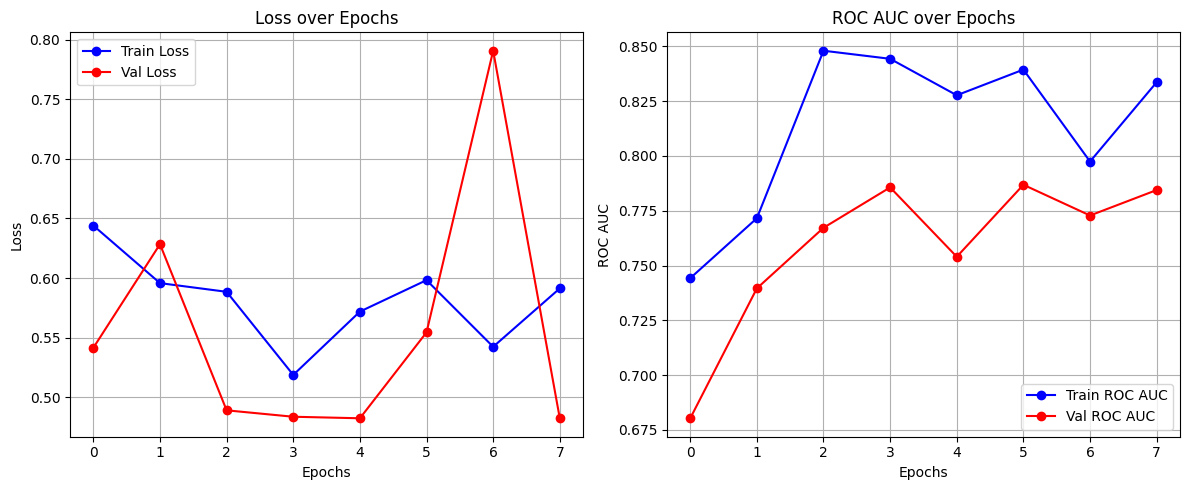

In [21]:
# Use Adam optimizer with weight decay (L2 regularization)
optimizer = Adam(model_5.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight decay

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    model_5.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model_5(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 8  # Reduce one epoch to fit  experiment
for epoch in range(epochs):
    model_5.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model_5(imgs)

        # Ensure labels have the same shape as outputs
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on the validation set
    model_5.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            outputs = model_5(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(val_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ResNet50 didn't perform well for this dataset

# Transformers

In [22]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Dataset paths
root_directory = '/kaggle/input/iuss-23-24-automatic-diagnosis-breast-cancer/training_set'
benign_folder = f'{root_directory}/benign'
malignant_folder = f'{root_directory}/malignant'

In [24]:
# Dataset Creation Function
def build_dataset_dataframe(dataset_directory):
    dataset_info = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}
    
    for category in ['benign', 'malignant']:
        category_directory = os.path.join(dataset_directory, category)
        for file in os.listdir(category_directory):
            if file.endswith('.png') and not '_mask' in file:
                study_identifier = file.split('.')[0]
                image_path = os.path.join(category_directory, file)
                img = Image.open(image_path)
                x_dim, y_dim = img.size
                mask_count = sum(1 for f in os.listdir(category_directory) if f.startswith(study_identifier) and '_mask' in f)
                dataset_info['x_dim'].append(x_dim)
                dataset_info['y_dim'].append(y_dim)
                dataset_info['label'].append(category)
                dataset_info['num_of_masks'].append(mask_count)
                dataset_info['path'].append(image_path)

    return pd.DataFrame(dataset_info)

# Load dataset
dataset_df = build_dataset_dataframe(root_directory)

# Dataset Split (Train/Validation)
train_df, validation_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])


In [25]:
# Transformation pipeline (only resize and convert to tensor)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),          # Convert to tensor and scale to [0, 1]
])

In [26]:
# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Return the image and its corresponding label
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label


In [28]:
# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=image_transform)
validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=False, num_workers=4)


In [29]:
# Load the pretrained Vision Transformer (ViT) model
from transformers import ViTForImageClassification, ViTFeatureExtractor
vit_model_name = "google/vit-base-patch16-224-in21k"  # Pre-trained ViT model
model_vit = ViTForImageClassification.from_pretrained(vit_model_name, num_labels=1)  # For binary classification (1 output)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Using device: cuda


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch [1/20], Train Loss: 0.6227, Train ROC AUC: 0.4274, Val Loss: 0.6061, Val ROC AUC: 0.4173
Epoch [2/20], Train Loss: 0.6118, Train ROC AUC: 0.5610, Val Loss: 0.6054, Val ROC AUC: 0.5527
Epoch [3/20], Train Loss: 0.6068, Train ROC AUC: 0.4268, Val Loss: 0.6055, Val ROC AUC: 0.4183
Epoch [4/20], Train Loss: 0.6157, Train ROC AUC: 0.4285, Val Loss: 0.6308, Val ROC AUC: 0.4243
Epoch [5/20], Train Loss: 0.6290, Train ROC AUC: 0.4469, Val Loss: 0.6030, Val ROC AUC: 0.4413
Epoch [6/20], Train Loss: 0.6118, Train ROC AUC: 0.4468, Val Loss: 0.6147, Val ROC AUC: 0.4389
Epoch [7/20], Train Loss: 0.6113, Train ROC AUC: 0.4336, Val Loss: 0.6041, Val ROC AUC: 0.4437
Epoch [8/20], Train Loss: 0.6094, Train ROC AUC: 0.5081, Val Loss: 0.6038, Val ROC AUC: 0.4908
Epoch [9/20], Train Loss: 0.6022, Train ROC AUC: 0.4510, Val Loss: 0.6064, Val ROC AUC: 0.4541
Epoch [10/20], Train Loss: 0.6035, Train ROC AUC: 0.5160, Val Loss: 0.6222, Val ROC AUC: 0.4964
Epoch [11/20], Train Loss: 0.6154, Train ROC AUC:

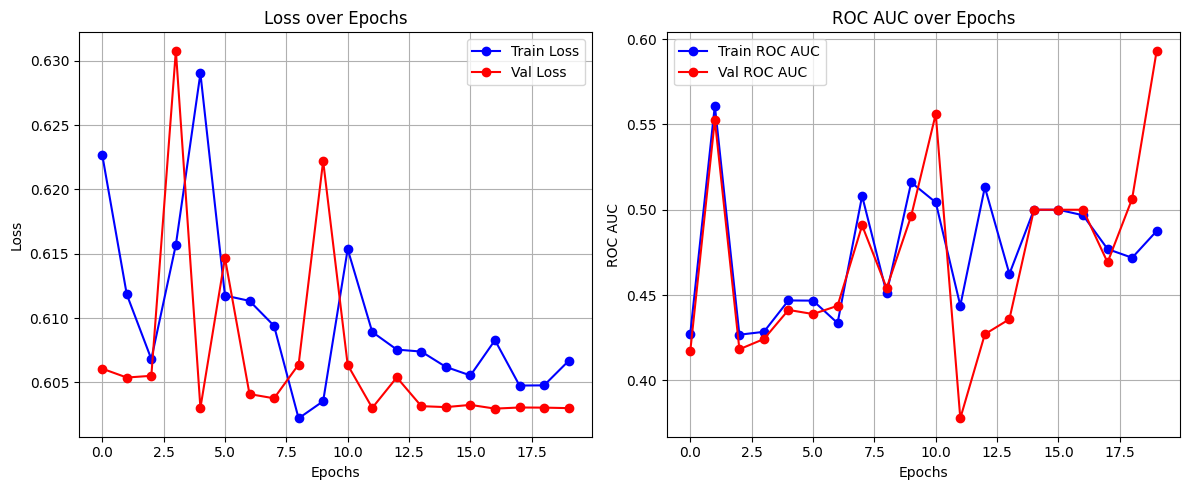

In [30]:
# Import the necessary libraries
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Load the pretrained Vision Transformer (ViT) model

vit_model_name = "google/vit-base-patch16-224-in21k"  # Pre-trained ViT model
model_vit = ViTForImageClassification.from_pretrained(vit_model_name, num_labels=1)  # For binary classification (1 output)

# Initialize the feature extractor for preprocessing images (ViT's image preprocessor)
image_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device (GPU or CPU)
model_vit.to(device)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = Adam(model_vit.parameters(), lr=0.001, weight_decay=1e-4)  # Adding weight decay to avoid overfitting

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Reduce learning rate if validation loss plateaus

# Helper function to calculate ROC AUC (Area Under the Receiver Operating Characteristic Curve)
def calculate_roc_auc(loader):
    model_vit.eval()  # Set model to evaluation mode (disables dropout and batch normalization)
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move images and labels to the same device as the model

            # Preprocess the images using the ViT feature extractor (e.g., resizing, normalization)
            inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

            # Get the outputs (logits) from the model
            outputs = model_vit(**inputs).logits
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get predicted probabilities for binary classification
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for ROC calculation
            all_preds.extend(probs.cpu().numpy())  # Move predicted probabilities to CPU

    # Calculate ROC AUC using the true labels and predicted probabilities
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC for each epoch (train and validation)
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20  # Set the number of epochs for training
for epoch in range(epochs):
    model_vit.train()  # Set model to training mode (enables dropout, etc.)
    running_train_loss = 0.0  # Initialize variable to accumulate training loss

    # Iterate through the training data in batches
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to the correct device (GPU/CPU)

        optimizer.zero_grad()  # Zero out gradients from the previous step

        # Preprocess the images using the ViT feature extractor (this applies transformations like resize)
        inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

        # Forward pass through the model to get predictions (logits)
        outputs = model_vit(**inputs).logits
        labels = labels.view(-1, 1)  # Ensure labels are in the correct shape for BCEWithLogitsLoss

        # Calculate loss using BCEWithLogitsLoss (appropriate for binary classification tasks)
        loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update model weights

        running_train_loss += loss.item()  # Accumulate training loss

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    model_vit.eval()  # Set model to evaluation mode (disables dropout and batch normalization)
    running_val_loss = 0.0  # Initialize variable to accumulate validation loss

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to the device

            # Preprocess the images using the ViT feature extractor (resizing, normalization)
            inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

            # Get model outputs (logits)
            outputs = model_vit(**inputs).logits
            labels = labels.view(-1, 1)  # Reshape labels to match the output shape
            loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Calculate loss
            running_val_loss += loss.item()  # Accumulate validation loss

    # Calculate the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both training and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print information for the current epoch (loss and ROC AUC for train and validation)
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler to adjust the learning rate based on validation loss
    scheduler.step(avg_val_loss)

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting the Loss curves (training and validation)
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the ROC AUC curves (training and validation)
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


**Tuning**

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch [1/20], Train Loss: 0.6134, Train ROC AUC: 0.6201, Val Loss: 0.6187, Val ROC AUC: 0.4816
Epoch [2/20], Train Loss: 0.6129, Train ROC AUC: 0.6413, Val Loss: 0.6030, Val ROC AUC: 0.6290
Epoch [3/20], Train Loss: 0.6105, Train ROC AUC: 0.7021, Val Loss: 0.6031, Val ROC AUC: 0.7260
Epoch [4/20], Train Loss: 0.6061, Train ROC AUC: 0.7436, Val Loss: 0.6031, Val ROC AUC: 0.7348
Epoch [5/20], Train Loss: 0.6088, Train ROC AUC: 0.6896, Val Loss: 0.6035, Val ROC AUC: 0.6763
Epoch [6/20], Train Loss: 0.6082, Train ROC AUC: 0.7665, Val Loss: 0.6035, Val ROC AUC: 0.6671
Epoch [7/20], Train Loss: 0.6074, Train ROC AUC: 0.7655, Val Loss: 0.6029, Val ROC AUC: 0.7522
Epoch [8/20], Train Loss: 0.6079, Train ROC AUC: 0.7823, Val Loss: 0.6029, Val ROC AUC: 0.7616
Epoch [9/20], Train Loss: 0.6053, Train ROC AUC: 0.7051, Val Loss: 0.6033, Val ROC AUC: 0.7244
Epoch [10/20], Train Loss: 0.6057, Train ROC AUC: 0.7078, Val Loss: 0.6032, Val ROC AUC: 0.7450
Epoch [11/20], Train Loss: 0.6070, Train ROC AUC:

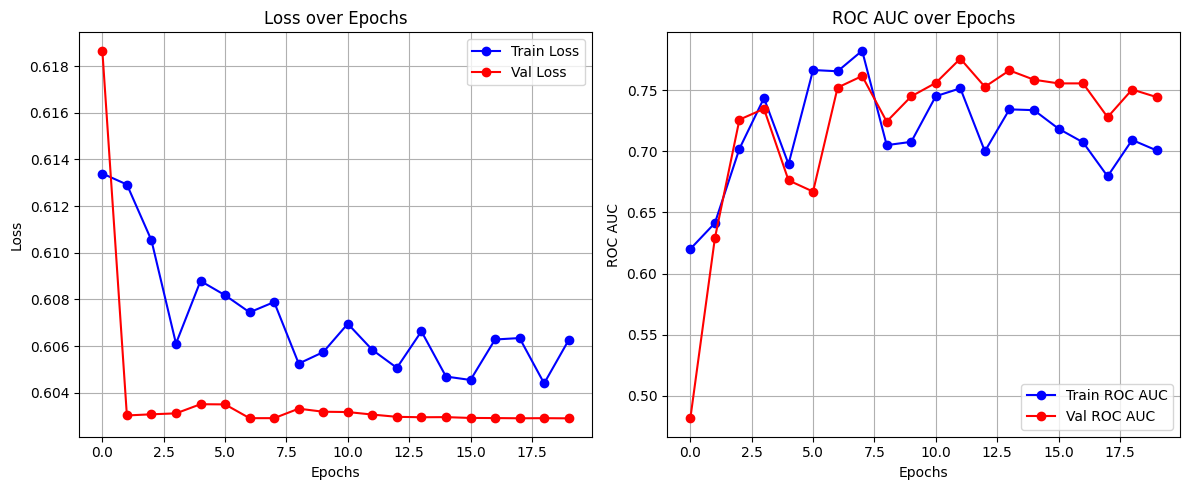

In [31]:
# Import necessary libraries
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Load the pretrained Vision Transformer (ViT) model
vit_model_name = "google/vit-base-patch16-224-in21k"  # Pre-trained ViT model from Hugging Face
model_vit = ViTForImageClassification.from_pretrained(vit_model_name, num_labels=1)  # For binary classification (1 output)

# Initialize the feature extractor for preprocessing images (ViT's image preprocessor)
image_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device (GPU or CPU)
model_vit.to(device)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = Adam(model_vit.parameters(), lr=1e-5, weight_decay=1e-4)  # Adding weight decay to avoid overfitting

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Reduce learning rate when validation loss plateaus

# Helper function to calculate ROC AUC (Area Under the Receiver Operating Characteristic Curve)
def calculate_roc_auc(loader):
    model_vit.eval()  # Set model to evaluation mode (disables dropout, batch normalization)
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move images and labels to the same device as the model

            # Preprocess the images using the ViT feature extractor (e.g., resizing, normalization)
            inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

            # Get the outputs (logits) from the model
            outputs = model_vit(**inputs).logits
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get predicted probabilities for binary classification
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for ROC calculation
            all_preds.extend(probs.cpu().numpy())  # Move predicted probabilities to CPU

    # Calculate ROC AUC using the true labels and predicted probabilities
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC for each epoch (train and validation)
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 20  # Set the number of epochs for training
for epoch in range(epochs):
    model_vit.train()  # Set model to training mode (enables dropout, etc.)
    running_train_loss = 0.0  # Initialize variable to accumulate training loss

    # Iterate through the training data in batches
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to the correct device (GPU/CPU)

        optimizer.zero_grad()  # Zero out gradients from the previous step

        # Preprocess the images using the ViT feature extractor (this applies transformations like resize)
        inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

        # Forward pass through the model to get predictions (logits)
        outputs = model_vit(**inputs).logits
        labels = labels.view(-1, 1)  # Ensure labels are in the correct shape for BCEWithLogitsLoss

        # Calculate loss using BCEWithLogitsLoss (appropriate for binary classification tasks)
        loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update model weights

        running_train_loss += loss.item()  # Accumulate training loss

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    model_vit.eval()  # Set model to evaluation mode (disables dropout and batch normalization)
    running_val_loss = 0.0  # Initialize variable to accumulate validation loss

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to the device

            # Preprocess the images using the ViT feature extractor (resizing, normalization)
            inputs = image_feature_extractor(images=imgs, return_tensors="pt").to(device)

            # Get model outputs (logits)
            outputs = model_vit(**inputs).logits
            labels = labels.view(-1, 1)  # Reshape labels to match the output shape
            loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Calculate loss
            running_val_loss += loss.item()  # Accumulate validation loss

    # Calculate the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both training and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print information for the current epoch (loss and ROC AUC for train and validation)
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler to adjust the learning rate based on validation loss
    scheduler.step(avg_val_loss)

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting the Loss curves (training and validation)
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting the ROC AUC curves (training and validation)
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


The Vision Transformer (ViT) might not be a good model or it might need more epoch. 

# DenseNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]


Using device: cuda
Epoch [1/50], Train Loss: 0.8160, Train ROC AUC: 0.7968, Val Loss: 0.7871, Val ROC AUC: 0.6603
Epoch [2/50], Train Loss: 0.6978, Train ROC AUC: 0.9643, Val Loss: 0.7288, Val ROC AUC: 0.7524
Epoch [3/50], Train Loss: 0.5986, Train ROC AUC: 0.9925, Val Loss: 0.6621, Val ROC AUC: 0.8029
Epoch [4/50], Train Loss: 0.5196, Train ROC AUC: 0.9963, Val Loss: 0.5933, Val ROC AUC: 0.8369
Epoch [5/50], Train Loss: 0.4426, Train ROC AUC: 0.9986, Val Loss: 0.5390, Val ROC AUC: 0.8654
Epoch [6/50], Train Loss: 0.3883, Train ROC AUC: 0.9993, Val Loss: 0.5039, Val ROC AUC: 0.8654
Epoch [7/50], Train Loss: 0.3332, Train ROC AUC: 0.9995, Val Loss: 0.4629, Val ROC AUC: 0.8834
Epoch [8/50], Train Loss: 0.2861, Train ROC AUC: 0.9999, Val Loss: 0.4263, Val ROC AUC: 0.8822
Epoch [9/50], Train Loss: 0.2372, Train ROC AUC: 1.0000, Val Loss: 0.3979, Val ROC AUC: 0.8822
Epoch [10/50], Train Loss: 0.2442, Train ROC AUC: 1.0000, Val Loss: 0.3783, Val ROC AUC: 0.8898
Epoch [11/50], Train Loss: 0.1

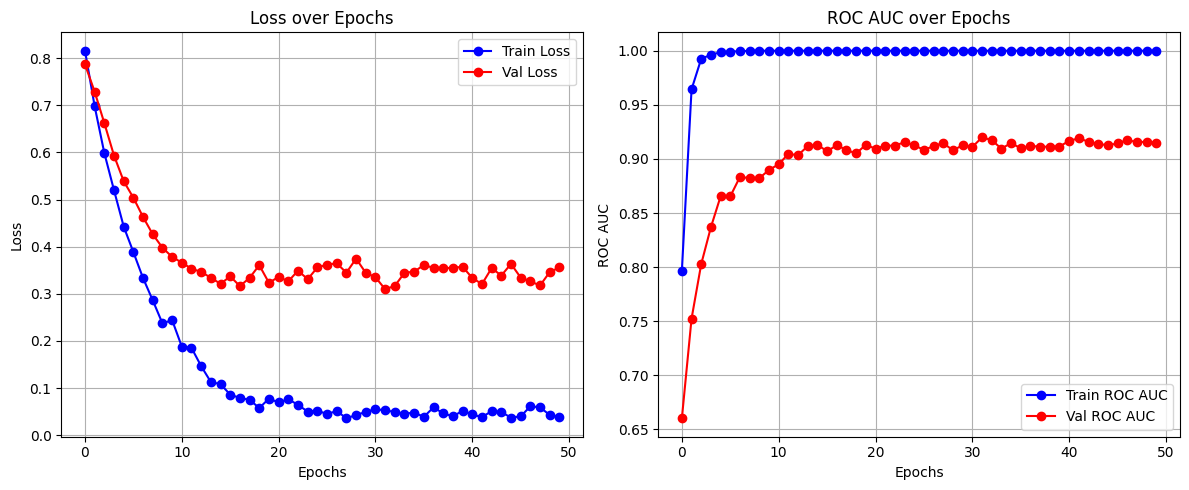

In [32]:
# Transformation pipeline (only resize and convert to tensor)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for DenseNet
    transforms.ToTensor(),          # Convert the image to a tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for DenseNet (ImageNet statistics)
])

# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe  # Store the dataframe that contains the image paths and labels
        self.transform = transform  # Store the transformation pipeline

    def __len__(self):
        return len(self.dataframe)  # Return the number of samples in the dataset

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']  # Get the path of the image
        img = Image.open(img_path).convert('RGB')  # Open the image and convert it to RGB format

        if self.transform:
            img = self.transform(img)  # Apply transformations (resize, normalization, etc.)

        # Convert the label to binary (1 for malignant, 0 for benign)
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label  # Return the transformed image and its corresponding label

# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=image_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=image_transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained DenseNet model
densenet_model = models.densenet121(pretrained=True)  # Load DenseNet121 model
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 1)  # Modify the classifier to output 1 label (binary classification)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device (GPU or CPU)
densenet_model.to(device)

# Use Adam optimizer with weight decay (L2 regularization)
optimizer = Adam(densenet_model.parameters(), lr=1e-5, weight_decay=1e-4)  # Adding weight decay to avoid overfitting

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)  # Reduce learning rate when validation loss plateaus

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    densenet_model.eval()  # Set the model to evaluation mode (disables dropout and batch normalization)
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move images and labels to the same device as the model

            # Forward pass: Get the outputs (logits) from the model
            outputs = densenet_model(imgs)
            probs = torch.sigmoid(outputs)  # Apply sigmoid to get predicted probabilities for binary classification
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for ROC calculation
            all_preds.extend(probs.cpu().numpy())  # Move predicted probabilities to CPU

    # Calculate ROC AUC using the true labels and predicted probabilities
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC for each epoch (train and validation)
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Training loop
epochs = 50  # Set the number of epochs for training
for epoch in range(epochs):
    densenet_model.train()  # Set model to training mode (enables dropout, etc.)
    running_train_loss = 0.0  # Initialize variable to accumulate training loss

    # Iterate through the training data in batches
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)  # Move data to the correct device (GPU/CPU)

        optimizer.zero_grad()  # Zero out gradients from the previous step

        # Forward pass
        outputs = densenet_model(imgs)
        labels = labels.view(-1, 1)  # Reshape labels to match the model output

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply the binary cross-entropy loss
        loss.backward()  # Backward pass to calculate gradients
        optimizer.step()  # Update model weights

        running_train_loss += loss.item()  # Accumulate training loss

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    densenet_model.eval()  # Set model to evaluation mode (disables dropout, batch normalization)
    running_val_loss = 0.0  # Initialize variable to accumulate validation loss

    with torch.no_grad():  # Disable gradient calculation for validation to save memory
        for imgs, labels in validation_loader:
            imgs, labels = imgs.to(device), labels.to(device)  # Move data to the correct device

            # Forward pass
            outputs = densenet_model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels to match the output shape
            loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()  # Accumulate validation loss

    # Calculate the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both training and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch information: Train Loss, Train ROC AUC, Val Loss, and Val ROC AUC
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler to adjust the learning rate based on validation loss
    scheduler.step(avg_val_loss)

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves (for both training and validation sets)
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(epochs), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves (for both training and validation sets)
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(epochs), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


**Tuming to deal with overfitting**
 a dropout layer with a 50% dropout rate in the classifier.
 Increased weight decay to 1e-4

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Epoch [1/20], Train Loss: 0.7951, Train ROC AUC: 0.5546, Val Loss: 0.6813, Val ROC AUC: 0.4439
Epoch [2/20], Train Loss: 0.7419, Train ROC AUC: 0.7447, Val Loss: 0.6880, Val ROC AUC: 0.5785
Epoch [3/20], Train Loss: 0.6845, Train ROC AUC: 0.8175, Val Loss: 0.6480, Val ROC AUC: 0.6803
Epoch [4/20], Train Loss: 0.6156, Train ROC AUC: 0.8604, Val Loss: 0.6053, Val ROC AUC: 0.7540
Epoch [5/20], Train Loss: 0.5807, Train ROC AUC: 0.8871, Val Loss: 0.5603, Val ROC AUC: 0.7841
Epoch [6/20], Train Loss: 0.5394, Train ROC AUC: 0.9014, Val Loss: 0.5298, Val ROC AUC: 0.8305
Epoch [7/20], Train Loss: 0.4617, Train ROC AUC: 0.9130, Val Loss: 0.5045, Val ROC AUC: 0.8369
Epoch [8/20], Train Loss: 0.4629, Train ROC AUC: 0.9261, Val Loss: 0.4707, Val ROC AUC: 0.8578
Epoch [9/20], Train Loss: 0.4146, Train ROC AUC: 0.9173, Val Loss: 0.4423, Val ROC AUC: 0.8790
Epoch [10/20], Train Loss: 0.3997, Train ROC AUC: 0.9395, Val Loss: 0.4280, Val ROC AUC: 0.8754
Epoch [11/20], Train Loss: 0.3

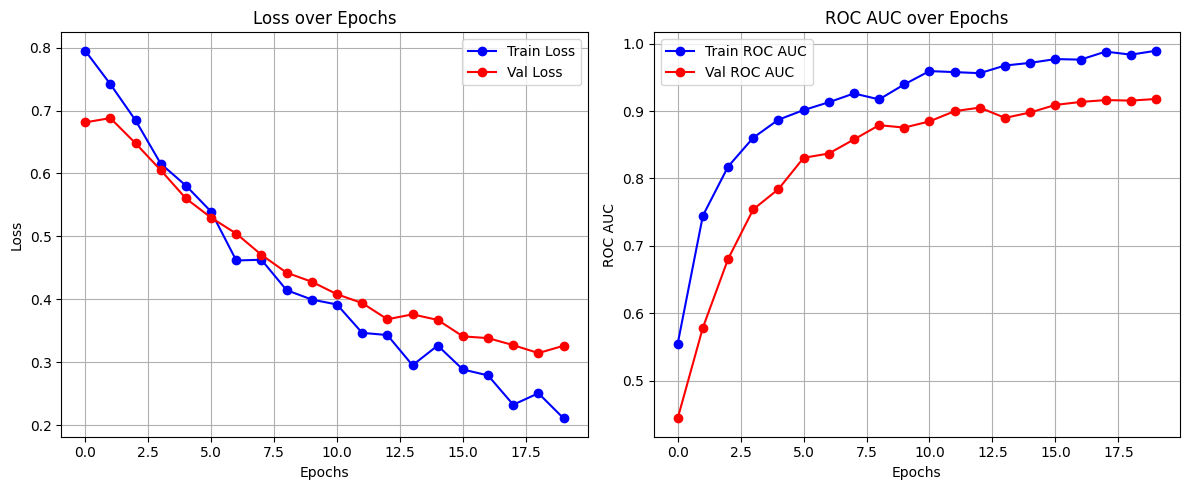

In [33]:


# Load dataset
dataset_df = build_dataset_dataframe(root_directory)

# Dataset Split (Train/Validation)
train_df, validation_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])

# Transformation pipeline with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by +/- 10 degrees
    transforms.Resize((224, 224)),      # Resize to 224x224 for DenseNet
    transforms.ToTensor(),              # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for DenseNet
])

# Transformation pipeline for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224 for DenseNet
    transforms.ToTensor(),              # Convert to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for DenseNet
])

# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Return the image and its corresponding label
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label

# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=val_transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained DenseNet model
densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 1)  # For binary classification (1 output)

# Add dropout to the classifier layer
densenet_model.classifier = nn.Sequential(
    nn.Dropout(0.5),  # Add dropout with 50% probability
    nn.Linear(densenet_model.classifier.in_features, 1)
)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device (GPU or CPU)
densenet_model.to(device)

# Use Adam optimizer with increased weight decay (L2 regularization)
optimizer = Adam(densenet_model.parameters(), lr=1e-5, weight_decay=1e-4)  # Increased weight decay

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    densenet_model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            # Move images and labels to the same device as the model
            imgs, labels = imgs.to(device), labels.to(device)

            # Get the outputs from the model
            outputs = densenet_model(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

# Training loop
epochs = 20  # Number of epochs
for epoch in range(epochs):
    densenet_model.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        # Move images and labels to the device (GPU/CPU)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = densenet_model(imgs)
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    densenet_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in validation_loader:
            # Move images and labels to the device (GPU/CPU)
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = densenet_model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = nn.BCEWithLogitsLoss()(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(len(train_roc_aucs)), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(len(val_roc_aucs)), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from PIL import Image

# Ensure the model is in evaluation mode and on the GPU
densenet_model.eval()
densenet_model.to(device)

# Define the directory where your test data is located
root_dir = '/kaggle/input/testing-set'

# Define the transformation (this may need to be adjusted based on your model's input requirements)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust based on model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for pretrained models
])

# Custom Dataset class to load the test images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, max_samples=100):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.image_files = self.image_files[:max_samples]  # Limit to the first 100 images

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # Return image and its filename

# Load the test dataset
test_dataset = CustomDataset(root_dir=root_dir, transform=test_transform, max_samples=100)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# List to store predictions
predictions = []
study_ids = []

# Generate predictions
with torch.no_grad():
    for imgs, filenames in test_loader:  # filenames will be used as study IDs
        imgs = imgs.to(device)  # Move data to GPU
        outputs = densenet_model(imgs)
        probs = torch.sigmoid(outputs)  # Get probabilities using sigmoid

        # Store the probability for the "Malignant" class
        predictions.extend(probs.cpu().numpy().flatten())  # Store individual float values
        study_ids.extend(filenames)  # Store the corresponding filenames as study IDs

# Map filenames to expected keys 
expected_keys = [f"T{i:03d}" for i in range(1, 101)]  

# Create a mapping between filenames and expected keys
# Assuming the filenames are in the correct order 
filename_to_key = {filename: key for filename, key in zip(study_ids, expected_keys)}

# Generate the correct 'Id' column using the mapping
corrected_ids = [filename_to_key[filename] for filename in study_ids]

# Convert predictions to a DataFrame with correct column names
submission_df = pd.DataFrame({
    'Id': corrected_ids,  # Use the corrected IDs
    'Predicted': predictions  # Use the raw probabilities
})

# Ensure predictions are in the correct range (0 to 1)
submission_df['Predicted'] = submission_df['Predicted'].clip(0, 1)  # Clip probabilities between 0 and 1

# Verify the number of rows in the submission DataFrame
print(f"Number of rows in submission DataFrame: {len(submission_df)}")

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Number of rows in submission DataFrame: 100
Submission file saved as 'submission.csv'


In [35]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from PIL import Image

# Ensure the model is in evaluation mode and on the GPU
densenet_model.eval()
densenet_model.to(device)

# Define the directory where your test data is located
root_dir = '/kaggle/input/testing-set'

# Define the transformation (this may need to be adjusted based on your model's input requirements)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example resize, adjust based on model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for pretrained models
])

# Custom Dataset class to load the test images
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]  # Assuming .jpg or .png files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # Return image and its filename

# Load the test dataset
test_dataset = CustomDataset(root_dir=root_dir, transform=test_transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# List to store predictions
predictions = []
study_ids = []

# Generate predictions
with torch.no_grad():
    for imgs, filenames in test_loader:  # filenames will be used as study IDs
        imgs = imgs.to(device)  # Move data to GPU
        outputs = densenet_model(imgs)
        probs = torch.sigmoid(outputs)  # Get probabilities using sigmoid

        # Adjust probabilities to meet the expected submission format
        malignant_probs = probs  # Class "Malignant" probability (range: 0.5 to 1)
        benign_probs = 1 - probs  # Class "Benign" probability (range: 0 to 0.5)

        # Store the probability for the "Malignant" class
        predictions.extend(malignant_probs.cpu().numpy())  # Move predictions to CPU and store
        study_ids.extend(filenames)  # Store the corresponding filenames as study IDs

# Convert predictions to a DataFrame with correct column names
submission_df = pd.DataFrame({
    'Id': study_ids,  # Rename 'study_id' to 'Id'
    'Predicted': predictions  # Rename 'prediction' to 'Predicted'
})

# Ensure predictions are in the correct range (0 to 1) for the "Malignant" class
submission_df['Predicted'] = submission_df['Predicted'].clip(0.5, 1)  # Clip "Malignant" probabilities between 0.5 and 1

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")


Submission file saved as 'submission.csv'


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 192MB/s]


Using device: cuda
Epoch [1/20], Train Loss: 0.9147, Train ROC AUC: 0.5878, Val Loss: 0.8720, Val ROC AUC: 0.5865
Epoch [2/20], Train Loss: 0.8733, Train ROC AUC: 0.7848, Val Loss: 0.8313, Val ROC AUC: 0.7472
Epoch [3/20], Train Loss: 0.8385, Train ROC AUC: 0.8605, Val Loss: 0.7980, Val ROC AUC: 0.8133
Epoch [4/20], Train Loss: 0.8038, Train ROC AUC: 0.8568, Val Loss: 0.7525, Val ROC AUC: 0.8558
Epoch [5/20], Train Loss: 0.7562, Train ROC AUC: 0.8914, Val Loss: 0.7246, Val ROC AUC: 0.8582
Epoch [6/20], Train Loss: 0.6902, Train ROC AUC: 0.8955, Val Loss: 0.6880, Val ROC AUC: 0.8658
Epoch [7/20], Train Loss: 0.6701, Train ROC AUC: 0.9102, Val Loss: 0.6447, Val ROC AUC: 0.8770
Epoch [8/20], Train Loss: 0.5969, Train ROC AUC: 0.9239, Val Loss: 0.6087, Val ROC AUC: 0.8850
Epoch [9/20], Train Loss: 0.6123, Train ROC AUC: 0.9392, Val Loss: 0.5726, Val ROC AUC: 0.8922
Epoch [10/20], Train Loss: 0.5684, Train ROC AUC: 0.9519, Val Loss: 0.5455, Val ROC AUC: 0.8974
Epoch [11/20], Train Loss: 0.4

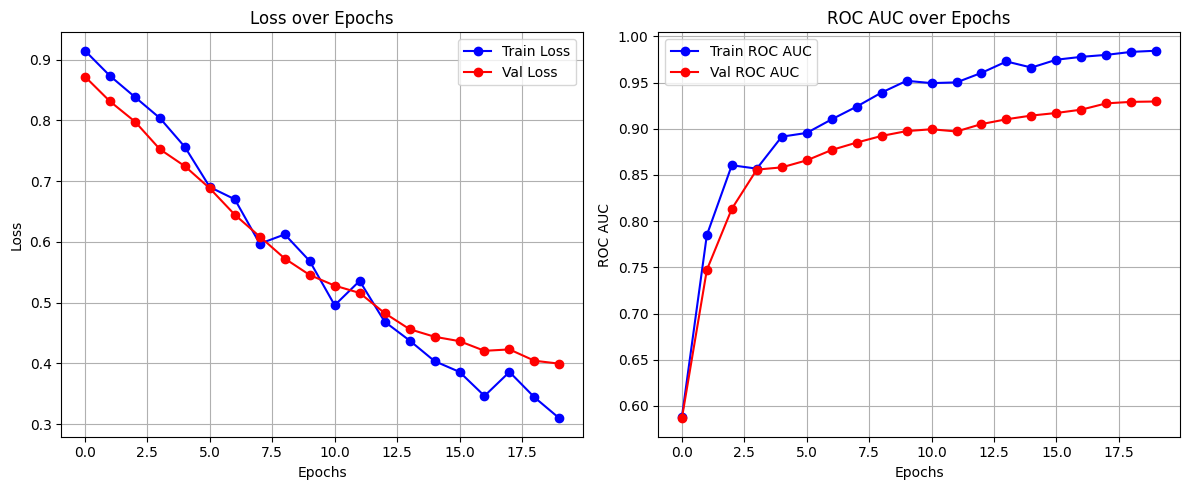

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Dataset paths
root_directory = '/kaggle/input/iuss-23-24-automatic-diagnosis-breast-cancer/training_set'
benign_folder = f'{root_directory}/benign'
malignant_folder = f'{root_directory}/malignant'

# Dataset Creation Function
def build_dataset_dataframe(dataset_directory):
    dataset_info = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}
    
    for category in ['benign', 'malignant']:
        category_directory = os.path.join(dataset_directory, category)
        for file in os.listdir(category_directory):
            if file.endswith('.png') and not '_mask' in file:
                study_identifier = file.split('.')[0]
                image_path = os.path.join(category_directory, file)
                img = Image.open(image_path)
                x_dim, y_dim = img.size
                mask_count = sum(1 for f in os.listdir(category_directory) if f.startswith(study_identifier) and '_mask' in f)
                dataset_info['x_dim'].append(x_dim)
                dataset_info['y_dim'].append(y_dim)
                dataset_info['label'].append(category)
                dataset_info['num_of_masks'].append(mask_count)
                dataset_info['path'].append(image_path)

    return pd.DataFrame(dataset_info)

# Load dataset
dataset_df = build_dataset_dataframe(root_directory)

# Dataset Split (Train/Validation)
train_df, validation_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])

# Transformation pipeline with advanced data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformation pipeline for validation (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Return the image and its corresponding label
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label

# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=val_transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained DenseNet model
densenet_model = models.densenet169(pretrained=True)
densenet_model.classifier = nn.Sequential(
    nn.Dropout(0.6),  # Increased dropout for regularization
    nn.Linear(densenet_model.classifier.in_features, 1)
)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the device (GPU or CPU)
densenet_model.to(device)

# Use AdamW optimizer with weight decay
optimizer = AdamW(densenet_model.parameters(), lr=1e-5, weight_decay=1e-4)

# Learning rate scheduler (Reduce learning rate when validation loss plateaus)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Weighted loss for class imbalance
pos_weight = torch.tensor([2.0]).to(device)  # Adjust based on your dataset's class distribution
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    densenet_model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            # Move images and labels to the same device as the model
            imgs, labels = imgs.to(device), labels.to(device)

            # Get the outputs from the model
            outputs = densenet_model(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

# Training loop
epochs = 20  # Number of epochs
for epoch in range(epochs):
    densenet_model.train()
    running_train_loss = 0.0
    for imgs, labels in train_loader:
        # Move images and labels to the device (GPU/CPU)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = densenet_model(imgs)
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    densenet_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in validation_loader:
            # Move images and labels to the device (GPU/CPU)
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = densenet_model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(len(train_roc_aucs)), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(len(val_roc_aucs)), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-squxfqx7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-squxfqx7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=acfd13bb701766118eceb1387bcc7254c6445215364da3069dfb16777a502369
  Stored in directory: /tmp/pip-ephem-wheel-cache-ws6sanpw/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Using device: cuda


100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]
Epoch 1/20: 100%|██████████| 28/28 [00:03<00:00,  7.34it/s]


Epoch [1/20], Train Loss: 0.8920, Train ROC AUC: 0.5685, Val Loss: 0.8682, Val ROC AUC: 0.6442


Epoch 2/20: 100%|██████████| 28/28 [00:03<00:00,  7.69it/s]


Epoch [2/20], Train Loss: 0.8618, Train ROC AUC: 0.6772, Val Loss: 0.8537, Val ROC AUC: 0.7208


Epoch 3/20: 100%|██████████| 28/28 [00:03<00:00,  7.58it/s]


Epoch [3/20], Train Loss: 0.8425, Train ROC AUC: 0.8466, Val Loss: 0.8349, Val ROC AUC: 0.7997


Epoch 4/20: 100%|██████████| 28/28 [00:03<00:00,  7.50it/s]


Epoch [4/20], Train Loss: 0.8196, Train ROC AUC: 0.9066, Val Loss: 0.8169, Val ROC AUC: 0.8321


Epoch 5/20: 100%|██████████| 28/28 [00:03<00:00,  7.02it/s]


Epoch [5/20], Train Loss: 0.7901, Train ROC AUC: 0.9339, Val Loss: 0.8025, Val ROC AUC: 0.8389


Epoch 6/20: 100%|██████████| 28/28 [00:03<00:00,  7.55it/s]


Epoch [6/20], Train Loss: 0.7667, Train ROC AUC: 0.9429, Val Loss: 0.7883, Val ROC AUC: 0.8598


Epoch 7/20: 100%|██████████| 28/28 [00:03<00:00,  7.55it/s]


Epoch [7/20], Train Loss: 0.7395, Train ROC AUC: 0.9681, Val Loss: 0.7680, Val ROC AUC: 0.8638


Epoch 8/20: 100%|██████████| 28/28 [00:03<00:00,  7.62it/s]


Epoch [8/20], Train Loss: 0.7530, Train ROC AUC: 0.9735, Val Loss: 0.7430, Val ROC AUC: 0.8770


Epoch 9/20: 100%|██████████| 28/28 [00:03<00:00,  7.39it/s]


Epoch [9/20], Train Loss: 0.6935, Train ROC AUC: 0.9823, Val Loss: 0.7298, Val ROC AUC: 0.8818


Epoch 10/20: 100%|██████████| 28/28 [00:03<00:00,  7.64it/s]


Epoch [10/20], Train Loss: 0.6629, Train ROC AUC: 0.9866, Val Loss: 0.7047, Val ROC AUC: 0.8998


Epoch 11/20: 100%|██████████| 28/28 [00:03<00:00,  7.66it/s]


Epoch [11/20], Train Loss: 0.6376, Train ROC AUC: 0.9884, Val Loss: 0.6860, Val ROC AUC: 0.8998


Epoch 12/20: 100%|██████████| 28/28 [00:03<00:00,  7.67it/s]


Epoch [12/20], Train Loss: 0.6188, Train ROC AUC: 0.9896, Val Loss: 0.6645, Val ROC AUC: 0.9079


Epoch 13/20: 100%|██████████| 28/28 [00:03<00:00,  7.62it/s]


Epoch [13/20], Train Loss: 0.5744, Train ROC AUC: 0.9908, Val Loss: 0.6392, Val ROC AUC: 0.9071


Epoch 14/20: 100%|██████████| 28/28 [00:03<00:00,  7.49it/s]


Epoch [14/20], Train Loss: 0.5488, Train ROC AUC: 0.9926, Val Loss: 0.6137, Val ROC AUC: 0.9091


Epoch 15/20: 100%|██████████| 28/28 [00:03<00:00,  7.52it/s]


Epoch [15/20], Train Loss: 0.5061, Train ROC AUC: 0.9938, Val Loss: 0.5930, Val ROC AUC: 0.9183


Epoch 16/20: 100%|██████████| 28/28 [00:03<00:00,  7.49it/s]


Epoch [16/20], Train Loss: 0.4910, Train ROC AUC: 0.9949, Val Loss: 0.5736, Val ROC AUC: 0.9115


Epoch 17/20: 100%|██████████| 28/28 [00:03<00:00,  7.62it/s]


Epoch [17/20], Train Loss: 0.4591, Train ROC AUC: 0.9959, Val Loss: 0.5529, Val ROC AUC: 0.9175


Epoch 18/20: 100%|██████████| 28/28 [00:03<00:00,  7.60it/s]


Epoch [18/20], Train Loss: 0.4357, Train ROC AUC: 0.9963, Val Loss: 0.5459, Val ROC AUC: 0.9191


Epoch 19/20: 100%|██████████| 28/28 [00:03<00:00,  7.59it/s]


Epoch [19/20], Train Loss: 0.3806, Train ROC AUC: 0.9971, Val Loss: 0.5279, Val ROC AUC: 0.9207


Epoch 20/20: 100%|██████████| 28/28 [00:03<00:00,  7.60it/s]


Epoch [20/20], Train Loss: 0.3658, Train ROC AUC: 0.9974, Val Loss: 0.5132, Val ROC AUC: 0.9187


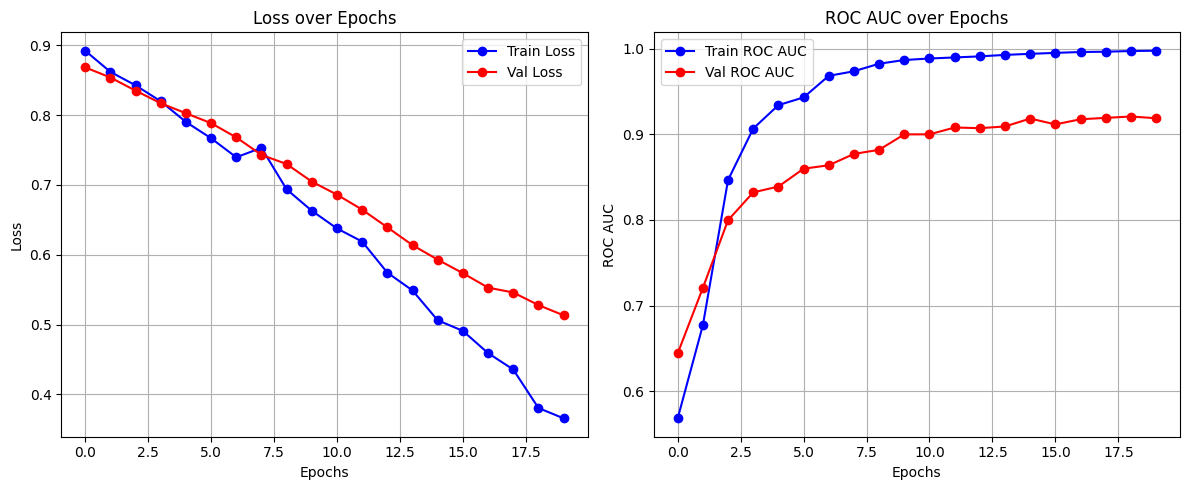

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# Dataset paths
root_directory = '/kaggle/input/iuss-23-24-automatic-diagnosis-breast-cancer/training_set'
benign_folder = f'{root_directory}/benign'
malignant_folder = f'{root_directory}/malignant'

# Dataset Creation Function
def build_dataset_dataframe(dataset_directory):
    dataset_info = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}
    
    for category in ['benign', 'malignant']:
        category_directory = os.path.join(dataset_directory, category)
        for file in os.listdir(category_directory):
            if file.endswith('.png') and not '_mask' in file:
                study_identifier = file.split('.')[0]
                image_path = os.path.join(category_directory, file)
                img = Image.open(image_path)
                x_dim, y_dim = img.size
                mask_count = sum(1 for f in os.listdir(category_directory) if f.startswith(study_identifier) and '_mask' in f)
                dataset_info['x_dim'].append(x_dim)
                dataset_info['y_dim'].append(y_dim)
                dataset_info['label'].append(category)
                dataset_info['num_of_masks'].append(mask_count)
                dataset_info['path'].append(image_path)

    return pd.DataFrame(dataset_info)

# Load dataset
dataset_df = build_dataset_dataframe(root_directory)

# Dataset Split (Train/Validation)
train_df, validation_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])

# Transformation pipeline for EfficientNet (no augmentation for simplicity)
efficientnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # EfficientNet normalization
])

# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Return the image and its corresponding label
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label

# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=efficientnet_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=efficientnet_transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load EfficientNet model from torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the EfficientNet model with pretrained weights
efficientnet_model = models.efficientnet_b0(pretrained=True)  # You can try other variants like b1, b2, etc.
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 1)  # Binary output classifier

# Move model to the device (GPU or CPU)
efficientnet_model.to(device)

# Use AdamW optimizer with weight decay
optimizer = AdamW(efficientnet_model.parameters(), lr=1e-5, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Weighted loss for class imbalance
pos_weight = torch.tensor([2.0]).to(device)  # Adjust based on your dataset's class distribution
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    efficientnet_model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            # Move images and labels to the same device as the model
            imgs, labels = imgs.to(device), labels.to(device)

            # Get the outputs from the model
            outputs = efficientnet_model(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

# Training loop
epochs = 20  # Number of epochs
for epoch in range(epochs):
    efficientnet_model.train()
    running_train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move images and labels to the device (GPU/CPU)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = efficientnet_model(imgs)
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    efficientnet_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in validation_loader:
            # Move images and labels to the device (GPU/CPU)
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = efficientnet_model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(len(train_roc_aucs)), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(len(val_roc_aucs)), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm

# Directory for test data
root_dir = '/kaggle/input/testing-set'

# Define the transformation for the test dataset (same as training, but without augmentation)
efficientnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # EfficientNet normalization
])

# Custom Dataset class for loading test images
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png') or f.endswith('.jpg')]  # Assuming .png or .jpg files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]  # Return image and its filename

# Load the EfficientNet model (same as during training)
device = "cuda" if torch.cuda.is_available() else "cpu"
efficientnet_model = models.efficientnet_b0(pretrained=True)  # Use EfficientNet-B0
efficientnet_model.classifier[1] = torch.nn.Linear(efficientnet_model.classifier[1].in_features, 1)  # Binary classifier
efficientnet_model.to(device)
efficientnet_model.eval()  # Set to evaluation mode

# Define the test dataset and dataloader
test_dataset = CustomTestDataset(root_dir=root_dir, transform=efficientnet_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# List to store predictions and corresponding study IDs
predictions = []
study_ids = []

# Generate predictions
with torch.no_grad():
    for imgs, filenames in tqdm(test_loader, desc="Generating Predictions"):
        imgs = imgs.to(device)  # Move to GPU if available
        outputs = efficientnet_model(imgs)
        probs = torch.sigmoid(outputs)  # Get probabilities for the "Malignant" class (0.5 to 1)
        
        predictions.extend(probs.cpu().numpy())  # Store the predictions on CPU
        study_ids.extend(filenames)  # Store filenames as study IDs

# Create a DataFrame for the required submission format
required_ids = [f"T{i:03d}" for i in range(1, 101)]  # Generate T001 to T100
submission_df = pd.DataFrame({'Id': required_ids, 'Predicted': 0.5})  # Initialize with default predictions (0.5)

# Map predictions to the required IDs
for study_id, pred in zip(study_ids, predictions):
    # Extract the numeric part of the study ID (e.g., "001" from "T001")
    if study_id.startswith("T") and study_id[1:].isdigit():
        idx = int(study_id[1:]) - 1  # Convert to zero-based index
        if 0 <= idx < 100:
            submission_df.at[idx, 'Predicted'] = pred[0]  # Update the prediction

# Ensure predictions are in the correct range (0 to 1)
submission_df['Predicted'] = submission_df['Predicted'].clip(0, 1)

# Save the predictions to a CSV file for submission
submission_df.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating Predictions: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]

Submission file saved as 'submission.csv'


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 209MB/s]  
Epoch 1/20: 100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Epoch [1/20], Train Loss: 0.8799, Train ROC AUC: 0.8738, Val Loss: 0.8088, Val ROC AUC: 0.7885


Epoch 2/20: 100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Epoch [2/20], Train Loss: 0.7447, Train ROC AUC: 0.9495, Val Loss: 0.6888, Val ROC AUC: 0.8790


Epoch 3/20: 100%|██████████| 28/28 [00:07<00:00,  3.73it/s]


Epoch [3/20], Train Loss: 0.5879, Train ROC AUC: 0.9750, Val Loss: 0.5738, Val ROC AUC: 0.9062


Epoch 4/20: 100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Epoch [4/20], Train Loss: 0.4527, Train ROC AUC: 0.9870, Val Loss: 0.5239, Val ROC AUC: 0.9034


Epoch 5/20: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Epoch [5/20], Train Loss: 0.3418, Train ROC AUC: 0.9948, Val Loss: 0.4891, Val ROC AUC: 0.9151


Epoch 6/20: 100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Epoch [6/20], Train Loss: 0.2705, Train ROC AUC: 0.9976, Val Loss: 0.4791, Val ROC AUC: 0.9179


Epoch 7/20: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Epoch [7/20], Train Loss: 0.2048, Train ROC AUC: 0.9991, Val Loss: 0.4579, Val ROC AUC: 0.9283


Epoch 8/20: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Epoch [8/20], Train Loss: 0.1625, Train ROC AUC: 0.9998, Val Loss: 0.5108, Val ROC AUC: 0.9123


Epoch 9/20: 100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Epoch [9/20], Train Loss: 0.1255, Train ROC AUC: 0.9998, Val Loss: 0.4358, Val ROC AUC: 0.9339


Epoch 10/20: 100%|██████████| 28/28 [00:07<00:00,  3.78it/s]


Epoch [10/20], Train Loss: 0.1050, Train ROC AUC: 0.9999, Val Loss: 0.5064, Val ROC AUC: 0.9291


Epoch 11/20: 100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Epoch [11/20], Train Loss: 0.0820, Train ROC AUC: 1.0000, Val Loss: 0.5047, Val ROC AUC: 0.9307


Epoch 12/20: 100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Epoch [12/20], Train Loss: 0.0617, Train ROC AUC: 1.0000, Val Loss: 0.5294, Val ROC AUC: 0.9327


Epoch 13/20: 100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Epoch [13/20], Train Loss: 0.0633, Train ROC AUC: 1.0000, Val Loss: 0.5988, Val ROC AUC: 0.9275


Epoch 14/20: 100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Epoch [14/20], Train Loss: 0.0519, Train ROC AUC: 1.0000, Val Loss: 0.5576, Val ROC AUC: 0.9319
Early stopping at epoch 14 as validation loss did not improve for 5 epochs.


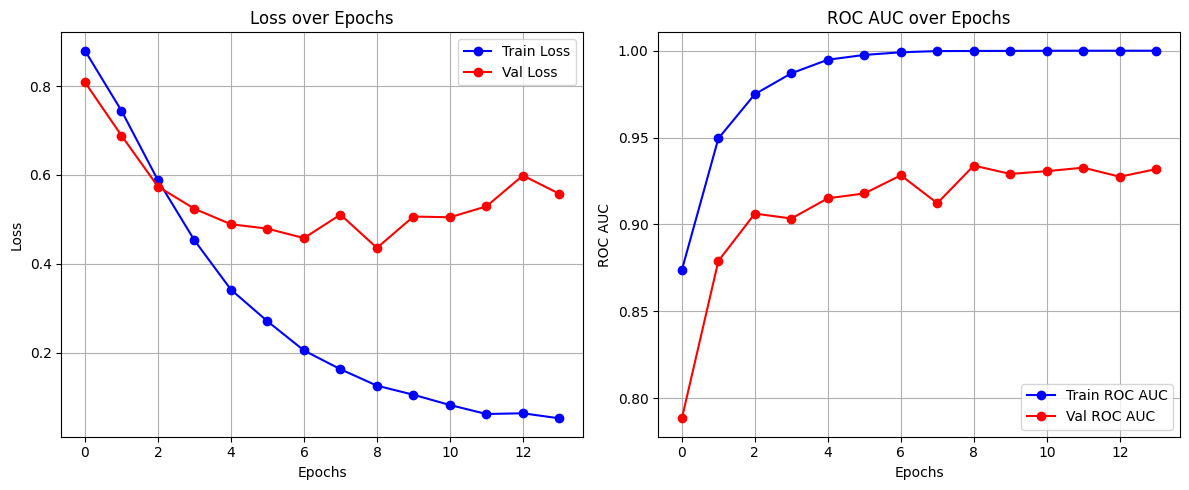

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# Dataset paths
root_directory = '/kaggle/input/iuss-23-24-automatic-diagnosis-breast-cancer/training_set'
benign_folder = f'{root_directory}/benign'
malignant_folder = f'{root_directory}/malignant'

# Dataset Creation Function
def build_dataset_dataframe(dataset_directory):
    dataset_info = {'x_dim': [], 'y_dim': [], 'label': [], 'num_of_masks': [], 'path': []}
    
    for category in ['benign', 'malignant']:
        category_directory = os.path.join(dataset_directory, category)
        for file in os.listdir(category_directory):
            if file.endswith('.png') and not '_mask' in file:
                study_identifier = file.split('.')[0]
                image_path = os.path.join(category_directory, file)
                img = Image.open(image_path)
                x_dim, y_dim = img.size
                mask_count = sum(1 for f in os.listdir(category_directory) if f.startswith(study_identifier) and '_mask' in f)
                dataset_info['x_dim'].append(x_dim)
                dataset_info['y_dim'].append(y_dim)
                dataset_info['label'].append(category)
                dataset_info['num_of_masks'].append(mask_count)
                dataset_info['path'].append(image_path)

    return pd.DataFrame(dataset_info)

# Load dataset
dataset_df = build_dataset_dataframe(root_directory)

# Dataset Split (Train/Validation)
train_df, validation_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df['label'])

# Transformation pipeline for ConvNeXt (no augmentation for simplicity)
convnext_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ConvNeXt expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ConvNeXt normalization
])

# Dataset class for PyTorch
class BreastCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Return the image and its corresponding label
        label = 1 if self.dataframe.iloc[idx]['label'] == 'malignant' else 0
        return img, label

# Create dataset and dataloaders
train_dataset = BreastCancerDataset(dataframe=train_df, transform=convnext_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

validation_dataset = BreastCancerDataset(dataframe=validation_df, transform=convnext_transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load ConvNeXt model from torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the ConvNeXt model with pretrained weights (ConvNeXt-Tiny by default)
convnext_model = models.convnext_tiny(pretrained=True)  # You can try other variants like convnext_small, convnext_base, etc.
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, 1)  # Binary output classifier

# Move model to the device (GPU or CPU)
convnext_model.to(device)

# Use AdamW optimizer with weight decay
optimizer = AdamW(convnext_model.parameters(), lr=1e-5, weight_decay=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Weighted loss for class imbalance
pos_weight = torch.tensor([2.0]).to(device)  # Adjust based on your dataset's class distribution
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Helper function to calculate ROC AUC
def calculate_roc_auc(loader):
    convnext_model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            # Move images and labels to the same device as the model
            imgs, labels = imgs.to(device), labels.to(device)

            # Get the outputs from the model
            outputs = convnext_model(imgs)
            probs = torch.sigmoid(outputs)  # Get the predicted probabilities
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Calculate ROC AUC
    auc = roc_auc_score(all_labels, all_preds)
    return auc

# Lists to store the loss and ROC AUC at each epoch
train_losses = []
val_losses = []
train_roc_aucs = []
val_roc_aucs = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0

# Training loop
epochs = 20  # Number of epochs
for epoch in range(epochs):
    convnext_model.train()
    running_train_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # Move images and labels to the device (GPU/CPU)
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = convnext_model(imgs)
        labels = labels.view(-1, 1)  # Reshape labels to [batch_size, 1]

        # Calculate loss (using BCEWithLogitsLoss for binary classification)
        loss = criterion(outputs, labels.float())  # Apply loss function
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_train_loss += loss.item()

    # Calculate the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate on the validation set
    convnext_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in validation_loader:
            # Move images and labels to the device (GPU/CPU)
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = convnext_model(imgs)
            labels = labels.view(-1, 1)  # Reshape labels
            loss = criterion(outputs, labels.float())  # Apply loss function
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)

    # Calculate ROC AUC for both train and validation sets
    train_roc_auc = calculate_roc_auc(train_loader)
    val_roc_auc = calculate_roc_auc(validation_loader)

    train_roc_aucs.append(train_roc_auc)
    val_roc_aucs.append(val_roc_auc)

    # Print epoch info
    print(f'Epoch [{epoch+1}/{epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train ROC AUC: {train_roc_auc:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.")
            break

# Plotting the training and validation loss/ROC AUC curves
plt.figure(figsize=(12, 5))

# Plotting Loss curves
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, marker='o', linestyle='-', color='r', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting ROC AUC curves
plt.subplot(1, 2, 2)
plt.plot(range(len(train_roc_aucs)), train_roc_aucs, marker='o', linestyle='-', color='b', label='Train ROC AUC')
plt.plot(range(len(val_roc_aucs)), val_roc_aucs, marker='o', linestyle='-', color='r', label='Val ROC AUC')
plt.title('ROC AUC over Epochs')
plt.xlabel('Epochs')
plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


> Comments: As I used Kaggle notebooks and their GPU, I faced several problems with sessions ending or restarting. For this reason, I repeated several codes like library, transformer, loading data, etc., because I felt it was so hard to go back and forth several times to see which box of code I needed to run. That's why sometimes I tried to put everything in one box and ran the code.